In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Toy Bee Finding Game

The bee is at an unknown location, $\theta \in [0,10]^2$.

We can make an observation, $y$ in direction $\xi$. This observation is a triplet of signal strengths at three angles around the actual angle (and transmitter) requested, $\xi$.

We need: $p(y|\theta, \xi)$:

I'll model that here with:

In [2]:
transmitter_locations = np.array([[0,0],[10,0]])

def get_dist_of_y_given_theta_xi(theta,xi):
    """
    Returns the probability distribution of observation y, given theta and xi
    
    theta = location of bee, pass as an Mx2 matrix.
    xi = tuple of id and angle of transmitter
    """
    v = theta - transmitter_locations[xi[0]]
    ang = (np.arctan2(v[:,0],v[:,1]) - xi[1]+np.pi) % (np.pi*2) #angle to bee from the transmitter specified.
    sampleangles = np.array([-0.1,0,0.1])    
    #the expected signal strengths at these sampled angles -- given the bee is actually at 'ang'
    expected_ys = -30+20*np.exp(-(ang[None,:] + sampleangles[:,None]-np.pi)**2/(2*0.1**2)).T 
    return norm(expected_ys,2)

In [4]:
#for example, we will provide two possible locations [5,5] or [6,6], if xi is from transmitter 0, pointing
#at pi/4 radians (so we sample at about 0.68, 0.78 and 0.88 signal measurements)
py = get_dist_of_y_given_theta_xi(np.array([[5,5],[6,6]]),(0,np.pi/4))
py.rvs() #we get three values (the possible measurements at the three angles, asso

array([[-15.39630909,  -8.46082838, -16.05022478],
       [-17.8977911 ,  -8.35115909, -17.92755517]])

In [66]:
N = 1000
M = int(np.sqrt(N))

results = []
testangles = np.linspace(0,np.pi*2,16,endpoint=False)
for count,angle in enumerate(testangles):
    print("%d/%d" % (count,len(testangles)),end="\r")
    for transmitter_id in range(2):
        xi = (transmitter_id,angle)
        sum_p = 0
        
        for i in range(N):          
        
            # sample theta:
            theta = np.random.rand(1,2)*10 #possible locations of bees (our prior p(theta))
            # sample y|theta, xi
            py = get_dist_of_y_given_theta_xi(theta,xi)
            y_sample = py.rvs()
            
            #sample theta-prime M times...
            theta_prime = np.random.rand(M,2)*10 #possible locations of bees (our prior p(theta))
            pym = get_dist_of_y_given_theta_xi(theta_prime,xi)
            
            denom = np.mean(np.prod(pym.pdf(y_sample),1)) #compute 1/M * sum p(y_n | theta', xi)
            #divide p(y_n|theta_n,xi) by denom, to give sample
            sum_p += np.sum(py.logpdf(y_sample)) - np.log(denom) #this gives us log p(y|theta,xi) - log p(y|xi) <-- one sample of n for the EIG...
        #print(sum_p / N)
        results.append([sum_p / N, transmitter_id, angle])
results = np.array(results)

Text(0.5, 0, 'Angle / radians')

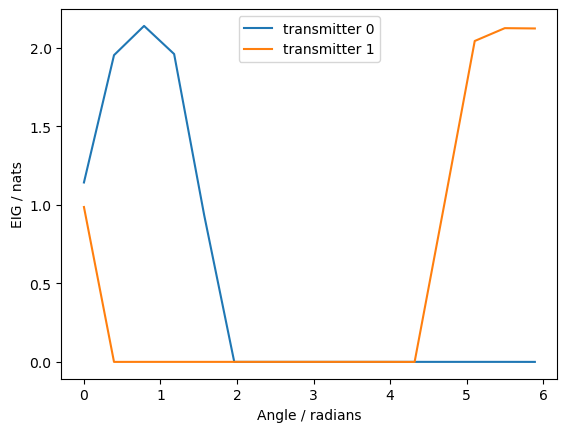

In [67]:
for i in range(2):
    plt.plot(testangles,results[i::2,0],label='transmitter %d' % i)
plt.legend()
plt.ylabel('EIG / nats')
plt.xlabel('Angle / radians')

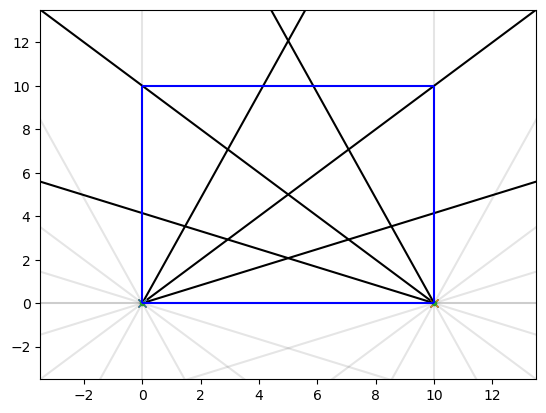

In [68]:
#here I'm just drawing all the choices that are within 0.5nats of the best EIG solution
for res in results:
    chosen = res[0]>np.max(results[:,0])-0.5
    #select = results[maxrowid]
    transmitter_loc = transmitter_locations[int(res[1])]
    ang = -res[2]-np.pi
    vector = 20*np.array([np.sin(ang),-np.cos(ang)])
    
    plt.plot(transmitter_loc[0],transmitter_loc[1],'x')
    plt.plot([transmitter_loc[0],transmitter_loc[0]+vector[0]],[transmitter_loc[1],transmitter_loc[1]+vector[1]],'-k',alpha=1 if chosen else 0.1)

plt.plot(transmitter_locations[:,0],transmitter_locations[:,1],'.')
plt.xlim([-3.5,13.5])
plt.ylim([-3.5,13.5])
plt.vlines([0,10],0,10,color='b')
plt.hlines([0,10],0,10,color='b')